<a href="https://colab.research.google.com/github/yeseul106/UROP_Software-Fault-Prediction/blob/main/Ternary_Classification_JM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt

In [2]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 원본 csv 파일 읽어오기
JM1_original = pd.read_csv('/content/drive/MyDrive/UROP/UROP dataset/JM1_Nomalize_Severity1.csv', encoding='cp949')
print(JM1_original.shape)
JM1_original.head(5)

(10878, 22)


,LOC_BLANK,BRANCH_COUNT,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_COMPLEXITY,DESIGN_COMPLEXITY,ESSENTIAL_COMPLEXITY,LOC_EXECUTABLE,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,LOC_TOTAL,3level1
0,1.000000,1.000000,0.111111,0.456395,1.000000,0.957606,0.682927,1.000000,0.369055,0.919297,1.000000,1.000000,1.000000,0.00,1.000000,1.000000,1.000000,1.000000,0.593567,0.377129,1.000000,2
1,0.000000,0.254545,0.000000,0.000000,0.270789,0.256858,0.079268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.327812,2
2,0.366890,0.586667,0.092593,0.168605,0.569296,0.543641,0.231707,0.562323,0.356243,0.510593,0.297776,0.536178,0.571970,0.00,0.297776,0.536129,0.572658,0.585240,0.396686,0.248175,0.529788,2
3,0.082774,0.033939,0.074074,0.122093,0.038380,0.044888,0.030488,0.047096,0.189793,0.110760,0.007466,0.061967,0.081152,0.02,0.007466,0.061963,0.097650,0.071956,0.117934,0.092457,0.064226,2
4,0.024609,0.489697,0.000000,0.049419,0.859275,0.002494,0.000000,0.288244,0.177612,0.492611,0.138190,0.257885,0.240848,0.00,0.138190,0.257888,0.269116,0.225092,0.790448,1.000000,0.244987,1


In [4]:
# 입력 데이터
input_data = JM1_original.iloc[:,:21]
print("input_data shape : ",input_data.shape)

input_data shape :  (10878, 21)


In [5]:
input_data = np.asarray(input_data,dtype=np.float)

In [6]:
# 정답 레이블
y_label = JM1_original.iloc[:,21].to_numpy()
print("y_label shape : ",y_label.shape)

y_label shape :  (10878,)


In [7]:
class_group = JM1_original['3level1'].value_counts()
class_group

0    8776
1    1759
2     343
Name: 3level1, dtype: int64

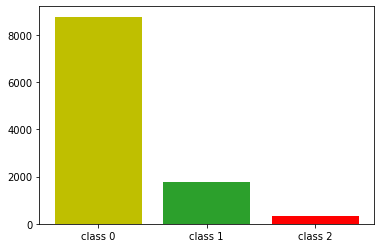

In [8]:
# 막대 그래프 그리기
import matplotlib.pyplot as plt

x = np.arange(3)
category = ['class 0', 'class 1', 'class 2']
colors = ['y', 'C2', 'r']

plt.bar(x, class_group, color=colors)
plt.xticks(x, category)

plt.show()

# **데이터 살펴보기**

- 클래스 별 산점도를 그려봄으로써, 데이터의 분포를 알아본다.

# **5-fold Cross Validation**

In [9]:
from sklearn.model_selection import StratifiedKFold
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# 5개의 파일로 쪼갬
n_fold = 5
seed = 0
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

#빈 metrics 배열 // confusion matrix를 구하기
fl_score_list = []
accuracy = []
loss = []
matrix = []

In [10]:
from typing import Pattern
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='loss', patience=100)

In [11]:
model = models.Sequential()
model.add(layers.Dense(32, input_shape = (21, )))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])
  
for train, test in skf.split(input_data, y_label):
  x_train, x_test = input_data[train], input_data[test]
  y_train, y_test = y_label[train], y_label[test]
  y_train = tf.keras.utils.to_categorical(y_train)
  y_test = tf.keras.utils.to_categorical(y_test)
  
  hist = model.fit(x_train, y_train, epochs=600, batch_size=32, verbose=1, callbacks=[early_stopping_callback])
  
  k_loss = "%.4f"%(model.evaluate(x_test, y_test)[0])
  k_accuracy = "%.4f"%(model.evaluate(x_test, y_test)[1])
  accuracy.append(k_accuracy)
  loss.append(k_loss)

  #예측 값 저장하기
  y_pred = model.predict(x_test)
  print(y_pred)

  y_pred_list = []
  #예측 값 shape 정리하기
  #3개의 클래스 확률 값 중 가장 큰 클래스로 바꾸기
  for i in range(len(y_pred)):
    list_tmp = y_pred[i].tolist()
    tmp = max(list_tmp)
    y_pred_list.append(list_tmp.index(tmp))

  from sklearn.metrics import plot_confusion_matrix
  from sklearn.metrics import f1_score
  print("y_pred_list.shape: ", len(y_pred_list))
  print("y_label.shape: ", y_label[test].shape)

  # #평가 매트릭 출력
  # plot_confusion_matrix(model,x_test,y_test, values_format='d', cmap='Blues')
  # plt.show()
  k_f1_score = f1_score(y_label[test], y_pred_list,  average = 'micro' )
  fl_score_list.append(k_f1_score)
  k_matrix = confusion_matrix(y_label[test], y_pred_list)
  matrix.append(k_matrix)

Epoch 1/600
272/272 [==============================] - 1s 2ms/step - loss: 0.6919 - categorical_accuracy: 0.7937
Epoch 2/600
272/272 [==============================] - 0s 2ms/step - loss: 0.5795 - categorical_accuracy: 0.8071
Epoch 3/600
272/272 [==============================] - 1s 2ms/step - loss: 0.5658 - categorical_accuracy: 0.8068
Epoch 4/600
272/272 [==============================] - 1s 2ms/step - loss: 0.5638 - categorical_accuracy: 0.8069
Epoch 5/600
272/272 [==============================] - 1s 2ms/step - loss: 0.5563 - categorical_accuracy: 0.8074
Epoch 6/600
272/272 [==============================] - 1s 2ms/step - loss: 0.5598 - categorical_accuracy: 0.8071
Epoch 7/600
272/272 [==============================] - 0s 2ms/step - loss: 0.5531 - categorical_accuracy: 0.8084
Epoch 8/600
272/272 [==============================] - 1s 2ms/step - loss: 0.5481 - categorical_accuracy: 0.8082
Epoch 9/600
272/272 [==============================] - 1s 2ms/step - loss: 0.5485 - categorical_

In [19]:
print("\n %.f fold accuracy:" % n_fold, accuracy)
print("모든 fold의 평균 accuracy: ", (float(accuracy[0]) + float(accuracy[1]) + float(accuracy[2]) + float(accuracy[3]) + float(accuracy[4])) / 5)

print("\n %.f fold loss:" % n_fold, loss)
print("모든 fold의 평균 loss: ", (float(loss[0]) + float(loss[1]) + float(loss[2]) + float(loss[3]) + float(loss[4])) / 5)

print("\n %.f fold f1_score:" % n_fold, fl_score_list)
print("모든 fold의 평균 f1_score: ", (float(fl_score_list[0]) + float(fl_score_list[1]) + float(fl_score_list[2]) + float(fl_score_list[3]) + float(fl_score_list[4])) / 5)

# print("\n %.f fold confusion_matrix:" % n_fold, matrix)
print("\n===모든 fold의 평균 matrix=== \n", (matrix[0] + matrix[1] + matrix[2] + matrix[3] + matrix[4]) // 5)


 5 fold accuracy: ['0.8056', '0.8111', '0.8070', '0.8133', '0.8106']
모든 fold의 평균 accuracy:  0.80952

 5 fold loss: ['0.5197', '0.5159', '0.5176', '0.5190', '0.5112']
모든 fold의 평균 loss:  0.51668

 5 fold f1_score: [0.8056066176470589, 0.8111213235294118, 0.8069852941176471, 0.8133333333333334, 0.8105747126436782]
모든 fold의 평균 f1_score:  0.8095242562542259

===모든 fold의 평균 matrix=== 
 [[1749    5    0]
 [ 340   11    0]
 [  63    4    0]]
